# Modeling inhibitor molecules of cancer protein kinases 
## Background
[Protein kinases](https://en.wikipedia.org/wiki/Protein_kinase) are enzymes involved in transferring a phosphate group to a protein. They can be understood as "activators" of protein via phosphorylation. All cells, including cancer cells, have a wide range of protein kinases involved in metabolism, synthesis of new molecules. One effective way to mitigate the proliferation of cancer cells is to deactivate central (upstream) protein kinases using inhibitor molecules, commonly used in chemotherapy (Bhular et al., 2018).

We are given a [dataset](https://www.kaggle.com/xiaotawkaggle/inhibitors) of molecules that can or cannot inhibit 8 different protein kinases involved in proliferation of cancer cells. The ability to inhibit is determined by the inhibition concentration needed to make half of the available kinases dysfunctional (IC50). On a molecular level, the denser is the environment with a molecule, the higher chance that it can bind to a kinase and induce a conformational on the kinase to alter its binding ability.

The format of this dataset is a molecule [fingerprint](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf) defined by RDKit hashed to a fixed-length vector of 6117 bits; hence, we have 6117 columns. Conceptually, each bit indicates the presense of a certain molecular structure (e.g. a carbonyl group). Thus, the closer the molecules are, the smaller the map distance between their footprints.

## Table of contents
- **Section 1**: Data processing
    - 1.0. Libraries
    - 1.1. Data loader
    - 1.2. Molecule visualizer
    - 1.3. Dimensionality reduction
- **Section 2**: Bayesian inference scheme
    - 2.1. Modeling versus classification
    - 2.2. Prior and likelihood
    - 2.3. Hierarchical Poisson factorization model
- **Section 3**: Posterior distribution evaluation
    - 3.1. Autocorrelation
    - 3.2. Posterior predictive check
- **Section 4**: Classification
    - 4.1. Classification with inference
    - 4.2. Validation metrics
- **Section 5**: Synthesis
    - 5.1 Discussion of the models
    - 5.2 Next steps

## Section 1: Data processing
### 1.0. Libraries

In [142]:
import os
import io # for reading byte-stream images
import math
import random

from PIL import Image
import requests
import pickle

import pystan
import numpy as np
import corex as ce
from scipy import sparse
from scipy import stats as sts
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import h5py
import pandas as pd
import matplotlib.pyplot as plt

### 1.1. Data loader

In [2]:
ROOT = './dataset'
HASH_LEN = 50

# dimensionality reduction (see section 1.3.)
def hash_features(feat_matrix):
    new_matrix = np.zeros((feat_matrix.shape[0], HASH_LEN), dtype=int)
    
    for row_idx, row in enumerate(feat_matrix):
        binary_str = ''.join([str(elem) for elem in row])
        decimal = int(binary_str, 2)
        hash_decimal = decimal % HASH_LEN
        hash_binary = format(hash_decimal, 'b') # trailing zeros
        formatted_binary = '0' * (HASH_LEN - len(hash_binary)) + hash_binary

        new_row = [int(elem) for elem in list(formatted_binary)] 
        new_matrix[row_idx] = new_row

    return new_matrix

class Dataset():
    def __init__(self, pk_name):
        # code for loading h5 file adapted from https://www.kaggle.com/xiaotawkaggle/inhibitors
        hf = h5py.File(os.path.join(ROOT, pk_name + ".h5"), "r")
    
        ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
        mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
        tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
        
        features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
        bin_features = (features >= 1).astype(int) # make sure data is binary
        
        self.features = bin_features
        self.hash_features = hash_features(bin_features)
        self.labels = hf["label"][()] # the label of each molecule
        self.chembl_ids = np.array([str(name)[2:-1] for name in hf["chembl_id"][()]]) # the name of each molecules
        
    def fetch_samples_with_label(self, label):
        filt_features = self.features[self.labels == label]
        filt_hash_features = self.hash_features[self.labels == label]
        filt_chembl_ids = self.chembl_ids[self.labels == label]
        filt_labels = self.labels[self.labels == label]
        
        return {
            "features": filt_features,
            "hash_features": filt_hash_features,
            "chembl_ids": filt_chembl_ids,
            "labels": filt_labels
        }
    
    def fetch_subset(self, start=0, end=None):
        filt_features = self.features[start:end]
        filt_hash_features = self.hash_features[start:end]
        filt_chembl_ids = self.chembl_ids[start:end]
        filt_labels = self.labels[start:end]
        
        return {
            "features": filt_features,
            "hash_features": filt_hash_features,
            "chembl_ids": filt_chembl_ids,
            "labels": filt_labels
        }

In [3]:
pk_abbr = pd.read_csv(os.path.join(ROOT, "abbr.csv"), header=None)
abbreviations = [abbr.lstrip() for abbr in pk_abbr[1]] # remove trailing space
pk_names = dict(zip(abbreviations, pk_abbr[0]))
pk_names

{'cdk2': 'Cyclin-dependent kinase 2',
 'egfr_erbB1': 'Epidermal growth factor receptor erbB1',
 'gsk3b': 'Glycogen synthase kinase-3 beta',
 'hgfr': 'Hepatocyte growth factor receptor',
 'map_k_p38a': 'MAP kinase p38 alpha',
 'tpk_lck': 'Tyrosine-protein kinase LCK',
 'tpk_src': 'Tyrosine-protein kinase SRC',
 'vegfr2': 'Vascular endothelial growth factor receptor 2'}

In [4]:
# initialize dataset
pk_datasets = {}
for pk_name in pk_names.keys():
    pk_datasets[pk_name] = Dataset(pk_name)

### 1.2. Molecule visualizer

In [5]:
chembl_api_link = 'https://www.ebi.ac.uk/chembl/api/data/image'

def display_molecules(chembl_ids, labels): # list of strings
    num_cols = 5
    num_rows = math.ceil(len(chembl_ids) / num_cols)
    plt.figure(figsize=(20, num_rows * 4), dpi=330)
               
    for idx, molec in enumerate(chembl_ids):
        plt.subplot(num_rows, num_cols, idx + 1)
        molec_url = os.path.join(chembl_api_link, molec)
        image_bytes = requests.get(molec_url).content
        image = np.array(Image.open(io.BytesIO(image_bytes)))
        plt.imshow(image)
        plt.axis('off')
        plt.title(molec + ': ' + str(labels[idx]))
               
    plt.show()

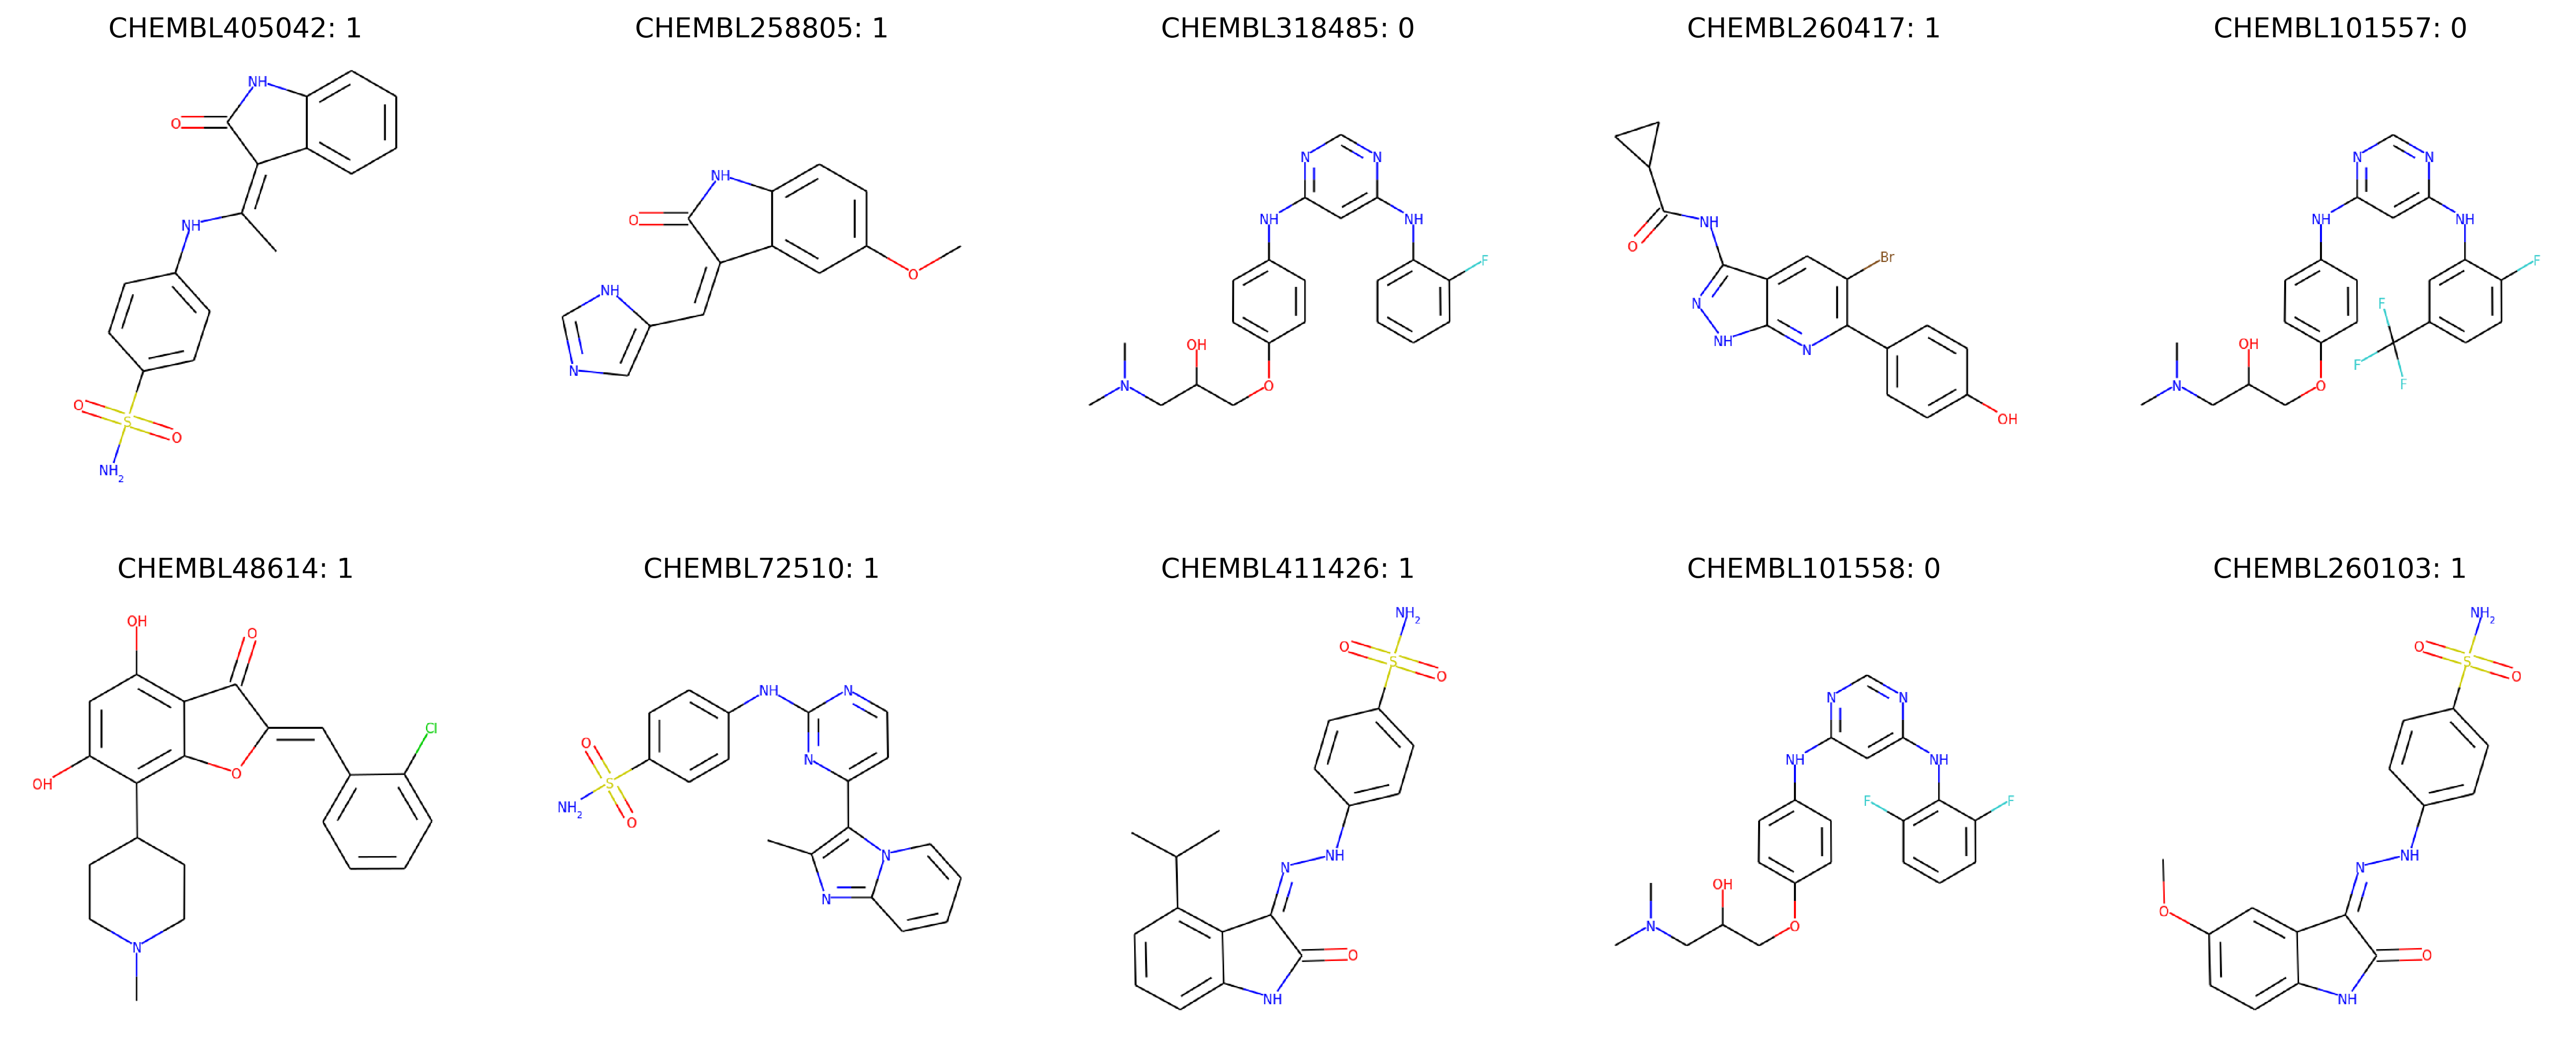

In [6]:
# visualize some molecules
sub = pk_datasets['cdk2'].fetch_subset(start=0, end=10)
display_molecules(sub['chembl_ids'], sub['labels'])

From these examples, conceptually we can imagine that the structure of 5-carbon with NH ring conjoined with a benzene 6-carbon ring probably plays some role in inhibiting (molecules 1, 2, 4, and 5). Molecule 3 does not have that feature and happens to be a non-inhibitor for CDK2. Thus, we can model the distribution over these features (molecular structures).

### 1.3. Dimensionality reduction
Our data looks like this:

In [7]:
sub = pk_datasets['cdk2'].features
print(sub)
print("Data dimensionality:", sub.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Data dimensionality: (1890, 6117)


For each protein kinase, the dataset is in the order of a thousand by eight thousand. There are two reasons why we need to reduce the dimension of the data:
1. Runtime is too long. After trying to model only on 5 data points with 6117 features, it took over 4000 seconds (more than an hour). Using all 1000+ datapoints as likelihood would take more than $4 * 10^6$ seconds which equates to 47 days!

<img src="img/so_long.jpg" alt="Kitten" title="A cute kitten" width="350" />


2. Because there are too many features and mostly the fields are zero, not much can be said about each feature. Instead, we get a misleading n_eff and R_hat from Stan. If we look at the posterior over the parameters, they are all similar which should not be the case.

<img src="img/too_big.jpg" alt="Kitten" title="A cute kitten" width="760" />

Each bit in the vector is supposed to indicate a certain substructure, not all bits are used (some molecule structures just don't go together). Therefore, we can tackle this with several approaches:
1. Principal component analysis (PCA). This method seems the most straightforward, however, it works very poorly on sparse data -- we can see it in the explainability of the variance of the components, none of them are more than 10%. Moreover, the features become continuous which does not make sense because before that we had boolean indicators saying "structure exists or not." Thus, we shall not use this.

<img src="img/too_inaccurate.png" alt="Kitten" title="A cute kitten" width="760" />

2. There are Sparse PCA implementations which supposedly should work better on sparse data. However, the one I tried in scikit takes way too long to find 100 components.

3. There is this [package](https://github.com/gregversteeg/bio_corex/) from Ver Steeg et al. (2015) called CorEx (correlation explanation) which maps binary data to latent binary variables while maximizing preserved variance. Sounds like magic but scales poorly for larger datasets due to its complexity of $O(num\_samples * num\_feat * num\_lat\_var)$. Even trying on a slice of the dataset, it takes way too long.

4. Last resort is to hash this data to new bit vector of shorter length (incurring some loss of overlap). To do so, we will convert the bit vector to base 10, mod by the new vector length, and tranform into a binary sequence. In a rare case when there is no overlap, each bit still should retain its uniqueness in terms of the molecular structure it represents. We start by confirming that the data is indeed sparse:

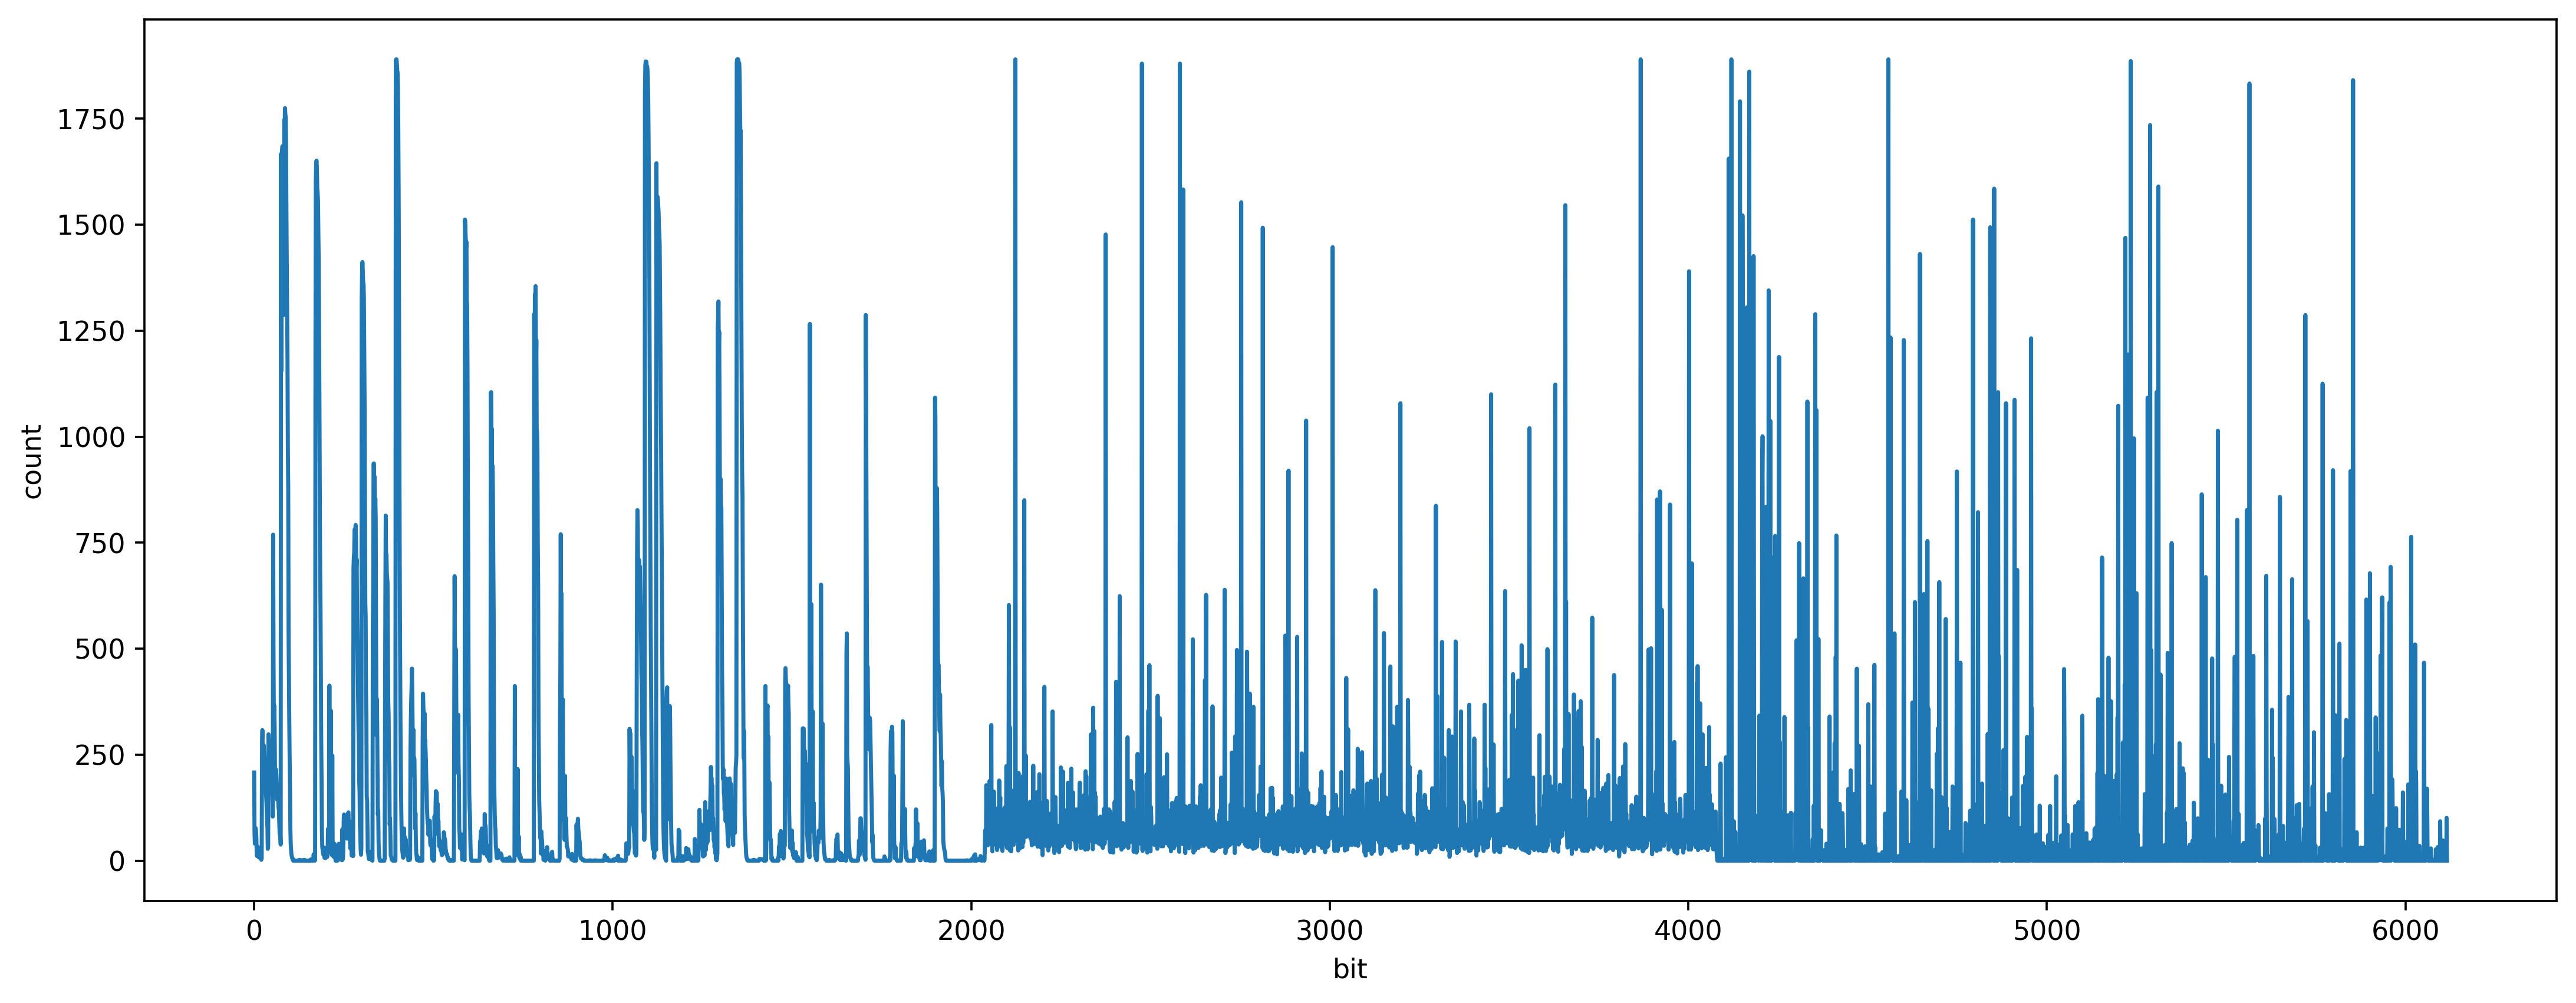

In [8]:
plt.figure(figsize=(16, 6), dpi=330)
plt.plot(np.sum(sub, axis=0))
plt.xlabel('bit')
plt.ylabel('count')
plt.show()

As we can see, the peaks are countable by hand (fewer than 50 of them). For ease of computability and still maintain a small enough amount of hash collisions, let's hash these values into a bit vector of length 50. Then, we wil have a total of $2^{50}$ permutations which should be good enough to capture most of the data.

In [9]:
hash_sub = pk_datasets['cdk2'].hash_features
print(hash_sub)
print("Data dimensionality:", hash_sub.shape)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
Data dimensionality: (1890, 50)


## Section 2: Inference scheme
### 2.1. Modeling versus classification

This is a classification problem in which we can the approach of finding the posterior over the weights for a regression; for example, by applying Bayesian logistic regression. However, a more exciting approach would be to model the process that "generated" inhibitor or non-inhibitor molecules and then use test statistics to classify. Approximating the generative process is important for the following reason:
1. We can put constraints on variables in a generative distribution. For example, if producing a certain molecular structure is expensive or has low success rate, we would not want to produce such molecule in real life. Then, we can sample from a truncated distribution that generates inhibitor molecules without unwanted structures and only test inhibitory capabilites of a smaller set of molecules.
2. From the underlying model we can understand better what exactly about those inhibitor molecules that allows them to inhibit a specific protein kinase. With this knowledge, researchers can further investigate binding mechanisms.

### 2.2. Prior and likelihood

We would like to model the generative process that "created" those inhibitory molecules. Since we have a binary sequence for each molecule, and bits corresponding to different molecular structures are activated semi-independently in the real world, we cannot use a multinomial with number of trials = 1 as a likelihood since it implies that if one bit is on, others cannot be on. Thus, we would have to use each bit as a datapoint and build likelihood over each bit. In this case, since we have outcomes 0 or 1, it can be a Bernoulli trial or a truncated Poisson distribution. In this case, we choose to go with the latter due to conceptual similarity with hierarchical Poisson factorization (HPF)'s likelihood (Gopalan et al., 2014).

Hierarchical Poisson factorization was first proposed in the context of recommender systems where users have preference for K latent attributes, and each movie has $K$ latent attributes. By multiplying the distribution of user preference of a latent attribute to the distribution of a movie having that attribute, we can get a the rate parameter for the Poisson distribution. The latter is used as a likelihood, and the data is user's preference of a movie. Equation taken from Gopalan et al. (2014) shown below.

<img src="img/hpf_formula.png" alt="Kitten" title="A cute kitten" width="540" />

There is a sound similarity between this original scenario and the molecules. For example, latent components can describe certain conformational features, binding ability, weight, size, etc. Then, the inhibitory molecules (one user) would have distributions over preferred latent components. Each bit in the feature vector is a molecular structure which also relates to the latent features (e.g. having a hydrocarbon chain makes a molecule more hydrophobic). The likelihood would be the presense of features (molecular structures) in an inhibitory molecule. One note is that we will model only one user because we care about the fact that something unites these inhibitory molecules and that they come from the same process. We can also make an argument that each molecule should have it's own parametrization $U=num\_molec$ (more hierarchy), just that the processes generated these molecules happen to share the inhibitory properties but they are distinct structurally. For the sake of computational simplicity, we will stick with $U=1$ and vary $K = \{1, 3\}$ to see how added model flexibility changes model fit.

Gopalan et al. (2014) do mention the use of Bayesian Poisson factorization (BPF) in which case, the all users and items share the same set of parameters. BPF is not suitable in our scenario because each feature (molecular structure) has its own distinct latent properties and we would like to capture that using a hierarchical model, described below. Blue circle indicates observed variables light grey indicate unobserved variables.

<img src="img/hpf_factor_graph.png" alt="Kitten" title="A cute kitten" width="760" />

### 2.3. Hierarchical Poisson factorization model
We will fit two different variations of the model, with varying number of latent components (1 and 3) to see if there is any difference in model fit as well as classification potential. In the interest of time, we will model the molecules for protein kinase CDK2. This same model should scale for any other protein kinase.

In [10]:
# Stan model for Hierarchical Poisson factorization
hpf_stan = ''' 

data {
    int<lower=1> num_molec;  // number of molecules
    int<lower=1> num_lat_comp;  // number of latent components
    int<lower=1> num_feat;  // number of features
    
    real<lower=0> alpha_xi;  // hyperpriors for latent components
    real<lower=0> beta_xi;
    real<lower=0> alpha_theta;
    
    int<lower=0, upper=1> obs[num_molec, num_feat];  // feature observations
    real<lower=0> alpha_eta;  // hyperpriors for features
    real<lower=0> beta_eta;
    real<lower=0> alpha_beta;
}

parameters {
    real<lower=0> xi;
    vector<lower=0>[num_lat_comp] theta;
    
    vector<lower=0>[num_feat] eta;
    matrix<lower=0>[num_feat, num_lat_comp] beta;
}

model {
    xi ~ gamma(alpha_xi, beta_xi);
    for (k in 1:num_lat_comp)
        theta[k] ~ gamma(alpha_theta, xi);
    
    for (i in 1:num_feat) {
        eta[i] ~ gamma(alpha_eta, beta_eta);
        for (k in 1:num_lat_comp)
            beta[i, k] ~ gamma(alpha_beta, eta[i]);
    }
    
    for (u in 1:num_molec)
        for (i in 1:num_feat)
            obs[u, i] ~ poisson(dot_product(theta, beta[i]));
}

'''

hpf_model = pystan.StanModel(model_code=hpf_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2acf096262544d6f79b3a7e6cf33c41b NOW.


Let's model the inhibitor molecules (label 1) and take only 80% of data (as "training") so that we have the rest (as "validation") to evaluate classification metrics on. We will randomize the data point selection and allow no overlaps as that could lead overestimation of model performance in a real test scenario.

In [11]:
TEST_SIZE = 0.2
cdk2_inhibitors = pk_datasets['cdk2'].fetch_samples_with_label(label=1)

X_train, X_test, y_train, y_test =\
    train_test_split(
        cdk2_inhibitors['hash_features'], cdk2_inhibitors['labels'],
        test_size=TEST_SIZE, random_state=146
    )

print("Training data dimensions:", X_train.shape)
print("Validation data dimensions:", X_test.shape)

Training data dimensions: (1016, 50)
Validation data dimensions: (255, 50)


Speaking of hyperprior parameters choice, since we have quite a lot of data, we don't have to worry about precisely tuning the prior beliefs. However, in this case we are trying to keep the $\alpha$ and $\beta$ parameters of the gamma distributions to be relatively small (1 or 2) to have a broader distribution, indicating no assumptions from our end. We cannot make assumptions here because it is unclear what each bit in the feature space really "mean," what properties it might have; therefore, it is safe to just be "uncertain" with a broader prior.

In [12]:
CACHE_DIR = './cache'
num_lat_comps = [1, 3]

# takes a total of 3-4 hours to run
for k in num_lat_comps:
    cdk2_data = {
        "num_molec": X_train.shape[0],
        "num_lat_comp": k,
        "num_feat": X_train.shape[1],

        "alpha_xi": 2,
        "beta_xi": 2,
        "alpha_theta": 2,

        "obs": X_train,
        "alpha_eta": 1,
        "beta_eta": 2,
        "alpha_beta": 2
    }
    
    # find posterior distribution
    cdk2_inhibitors_fit = hpf_model.sampling(data=cdk2_data)
    
    # save fitted results for each number of latent components
    with open(os.path.join(CACHE_DIR, 'cdk2_fit_{}lc.pkl'.format(k)), 'wb') as f:
        pickle.dump(cdk2_inhibitors_fit, f)

/home/munchic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


In [22]:
# retrieve models
cdk2_fit_1lc = pickle.load(open(os.path.join(CACHE_DIR, 'cdk2_fit_1lc.pkl'), 'rb'))
cdk2_fit_3lc = pickle.load(open(os.path.join(CACHE_DIR, 'cdk2_fit_3lc.pkl'), 'rb'))

In [28]:
print(cdk2_fit_1lc)

Inference for Stan model: anon_model_2acf096262544d6f79b3a7e6cf33c41b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
xi           2.01    0.01   0.99   0.59   1.24   1.85   2.62   4.26   8728    1.0
theta[1]   2.3e-5  3.5e-7 1.1e-5 8.1e-6 1.5e-5 2.1e-5 2.8e-5 4.9e-5    940    1.0
eta[1]       0.57  6.7e-3   0.51   0.04   0.21   0.43   0.79   1.88   5744    1.0
eta[2]       0.58  7.2e-3   0.51   0.04   0.22   0.43   0.79   1.97   4876    1.0
eta[3]       0.57  7.0e-3   0.51   0.04   0.22   0.43   0.76   1.91   5356    1.0
eta[4]       0.59  6.9e-3   0.53   0.05   0.21   0.44    0.8   1.95   5998    1.0
eta[5]       0.58  6.6e-3    0.5   0.05   0.21   0.43   0.81   1.87   5777    1.0
eta[6]       0.59  6.9e-3   0.54   0.04    0.2   0.44    0.8    2.0   6017    1.0
eta[7]       0.58  6.9e-3   0.51   0.04   0.21   0.42   0.78    1.9   549

Some `n_eff` here are quite misleading (larger than the number of drawn samples) -- probably because of residues in the autocorrelation. The convergence, `Rhat`, on the other hand, looks quite convincing on all variables.

## Section 3: Posterior distribution evaluation

### 3.1. Autocorrelation

In [48]:
def plot_acf(x):
    # code borrowed from Prof. Scheffler
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    The autocorrelation at lag = 0 is always 1 since the series is perfectly
    correlated with itself. You can ignore this value. The autocorrelation at
    all other values should be as small as possible, since independent samples
    have no correlation.
    '''
    
    plt.acorr(x, maxlags=40, detrend=lambda x: signal.detrend(x, type='constant'))

Since we have "only" 50 different variables for eta and beta, let's show them in a 10x10 plot and examine for anomalies (high autocorrelation).

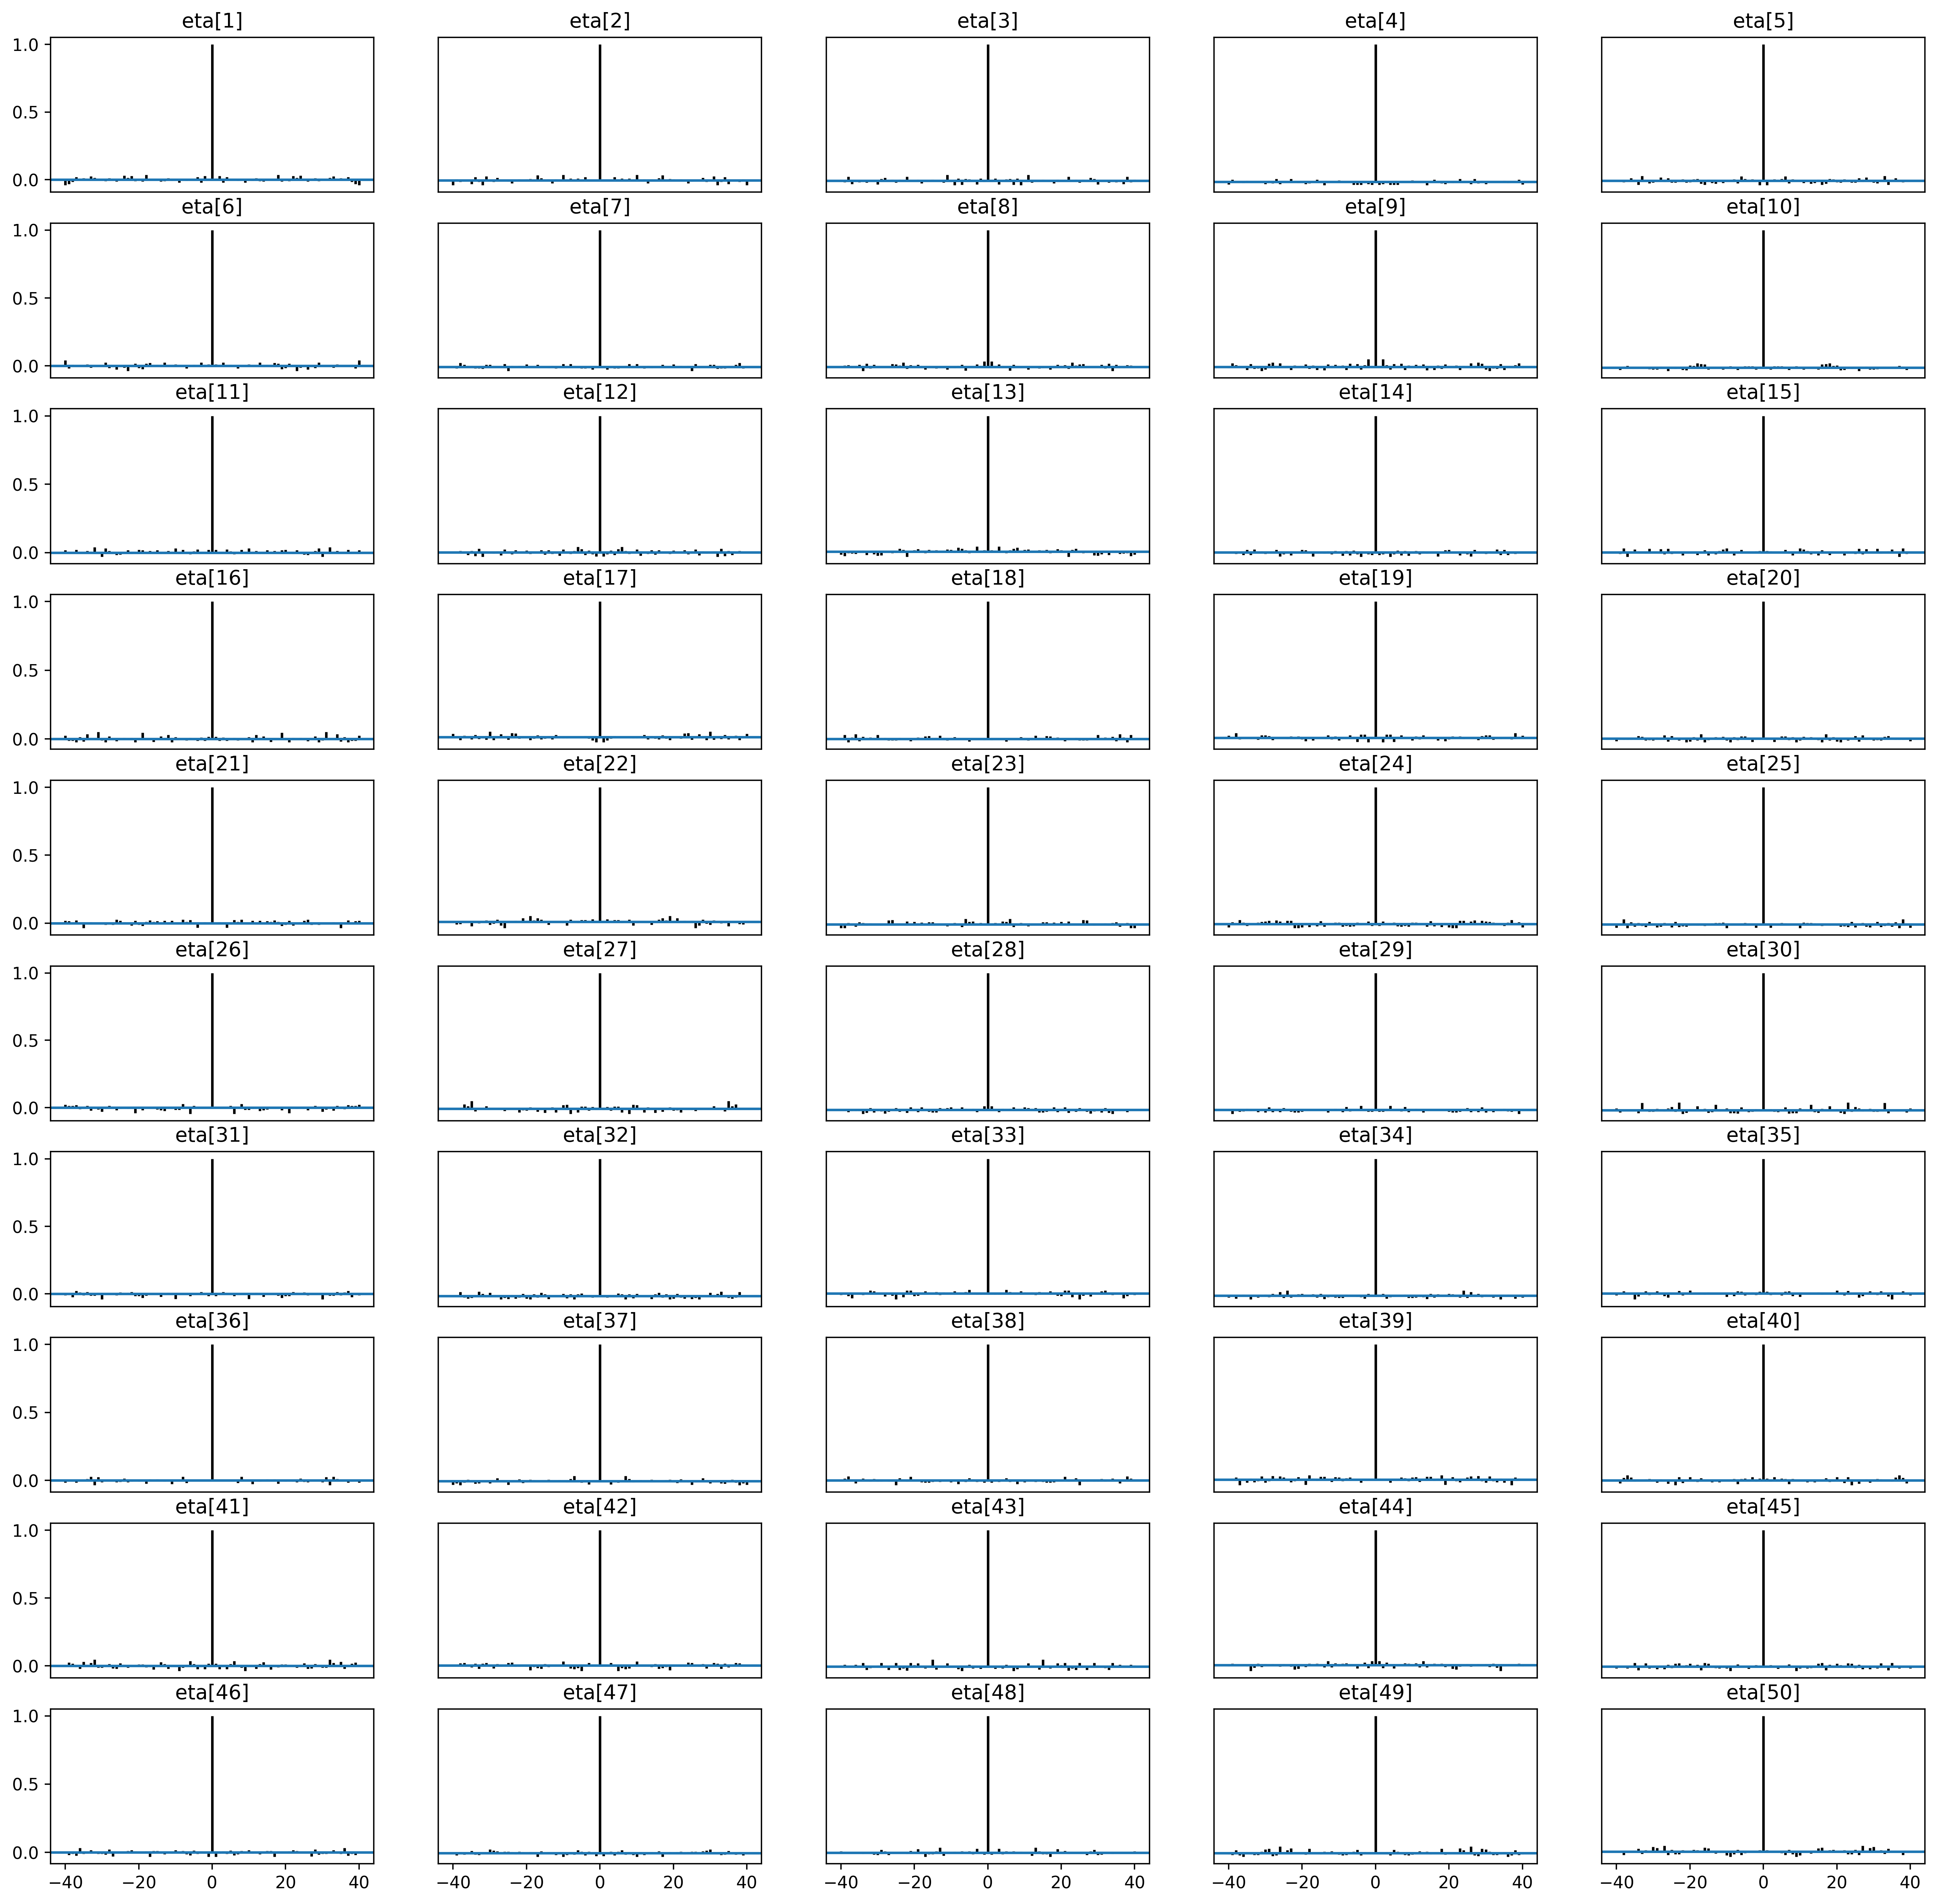

In [49]:
# autocorrelation plots for eta
plt.figure(figsize=(20, 20), dpi=330)

for i in range(HASH_LEN):
    plt.subplot(math.ceil(HASH_LEN / 5), 5, i + 1)
    plot_acf(cdk2_fit_1lc['eta'][:, i])
    plt.title('eta[{}]'.format(i + 1))
    if i < 45:
        plt.xticks([])
    if i % 5 > 0:
        plt.yticks([])
    
plt.show()

As we can see, all of parameters were able to converge correctly to the posterior distribution because the sampling looks uncorrelated and thus creates independent samples. Because there are small bumps up and down, possibly, the sum of their heights added up to something less than 1, bumping up the `n_eff`. There are no issues though!

With autocorrelation plots we can further check convergence for other variables and the other model (which, based on `Rhat` and `n_eff`, seem to have converged as well). To validate whether we're not missing any peaks that the sampler did not get to, we shall do a posterior predictive check.

### 3.2. Posterior predictive check
Posterior predictive check is essentially a test for how well the model fit the data and can describe the data it was fitted on. First, we need to draw the samples from the posteriors of $\beta$ and $\theta$, plug those into a Poisson and get the "new" data.


In [88]:
def hpf_posterior_pred(stan_fit):
    thetas = stan_fit['theta']
    betas = stan_fit['beta']
    samples = np.zeros((betas.shape[0], betas.shape[1]), dtype=int)
    
    # iterate through samples
    for i in range(betas.shape[0]):
        theta = thetas[i]
        beta = betas[i]
        lambdas = np.dot(beta, np.transpose(theta))
        
        sample = sts.poisson.rvs(lambdas)
        samples[i, :] = sample[:].astype(int)
        
    samples = (samples >= 1).astype(int) # turn >1 into 1
         
    return samples

In [92]:
post_pred = hpf_posterior_pred(cdk2_fit_3lc)
print(post_pred)
print("Dimensions:", post_pred.shape)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]]
Dimensions: (4000, 50)


Since the data is not continuous, we cannot really compare covariance matrix of the posterior predictive distribution versus the original data. Instead, a test statistic we can employ here is the mean pair-wise element-wise distance between two bit vectors (**not** map distance) for original data and sampled. We would like to sample a dataset of the same size as the original from the posterior predictive distribution many times, so that we get a distribution over the mean pair-wise element-wise distance. We would then check the p-value of the original data's statistic to see if it is within the simulated test statistic.

Due to implementational constraints, the sampler can only sample example 4000 molecules each time, and our data was about 1000 datapoints. To match the data size, we can just take a random subset of the 4000 points to match the size so that the test statistics were comparable.

In [135]:
def elementwise_distance(molec1, molec2):
    dist = np.sum(np.abs(molec1 - molec2))
    return dist
    
def mean_pairwise_distance(dataset):
    sz = dataset.shape[0] # number of datapoints
    num_comb = sz * (sz - 1) / 2 # all pair combinations
    mean_dist = 0
    
    for i in range(sz - 1):
        for j in range(i + 1, sz):
            mean_dist += elementwise_distance(dataset[i], dataset[j]) / num_comb
           
    return mean_dist

def simulate_test_statistic(stan_fit, data_sz, sim_iter=150):
    mean_dists = []
    
    for i in range(sim_iter):
        samples = hpf_posterior_pred(stan_fit)
        sub_idx = np.random.choice(range(samples.shape[0]), data_sz, replace=False)
        sub_samples = samples[sub_idx]
        mean_dists.append(mean_pairwise_distance(sub_samples))
        
    return np.array(mean_dists)

In [136]:
data_test_stat = mean_pairwise_distance(X_train)

In [137]:
# takes quite a while to run because the algorithm is brute-force
data_sz = X_train.shape[0]
pred_post_test_stats_1lc = simulate_test_statistic(cdk2_fit_1lc, data_sz)
pred_post_test_stats_3lc = simulate_test_statistic(cdk2_fit_3lc, data_sz)

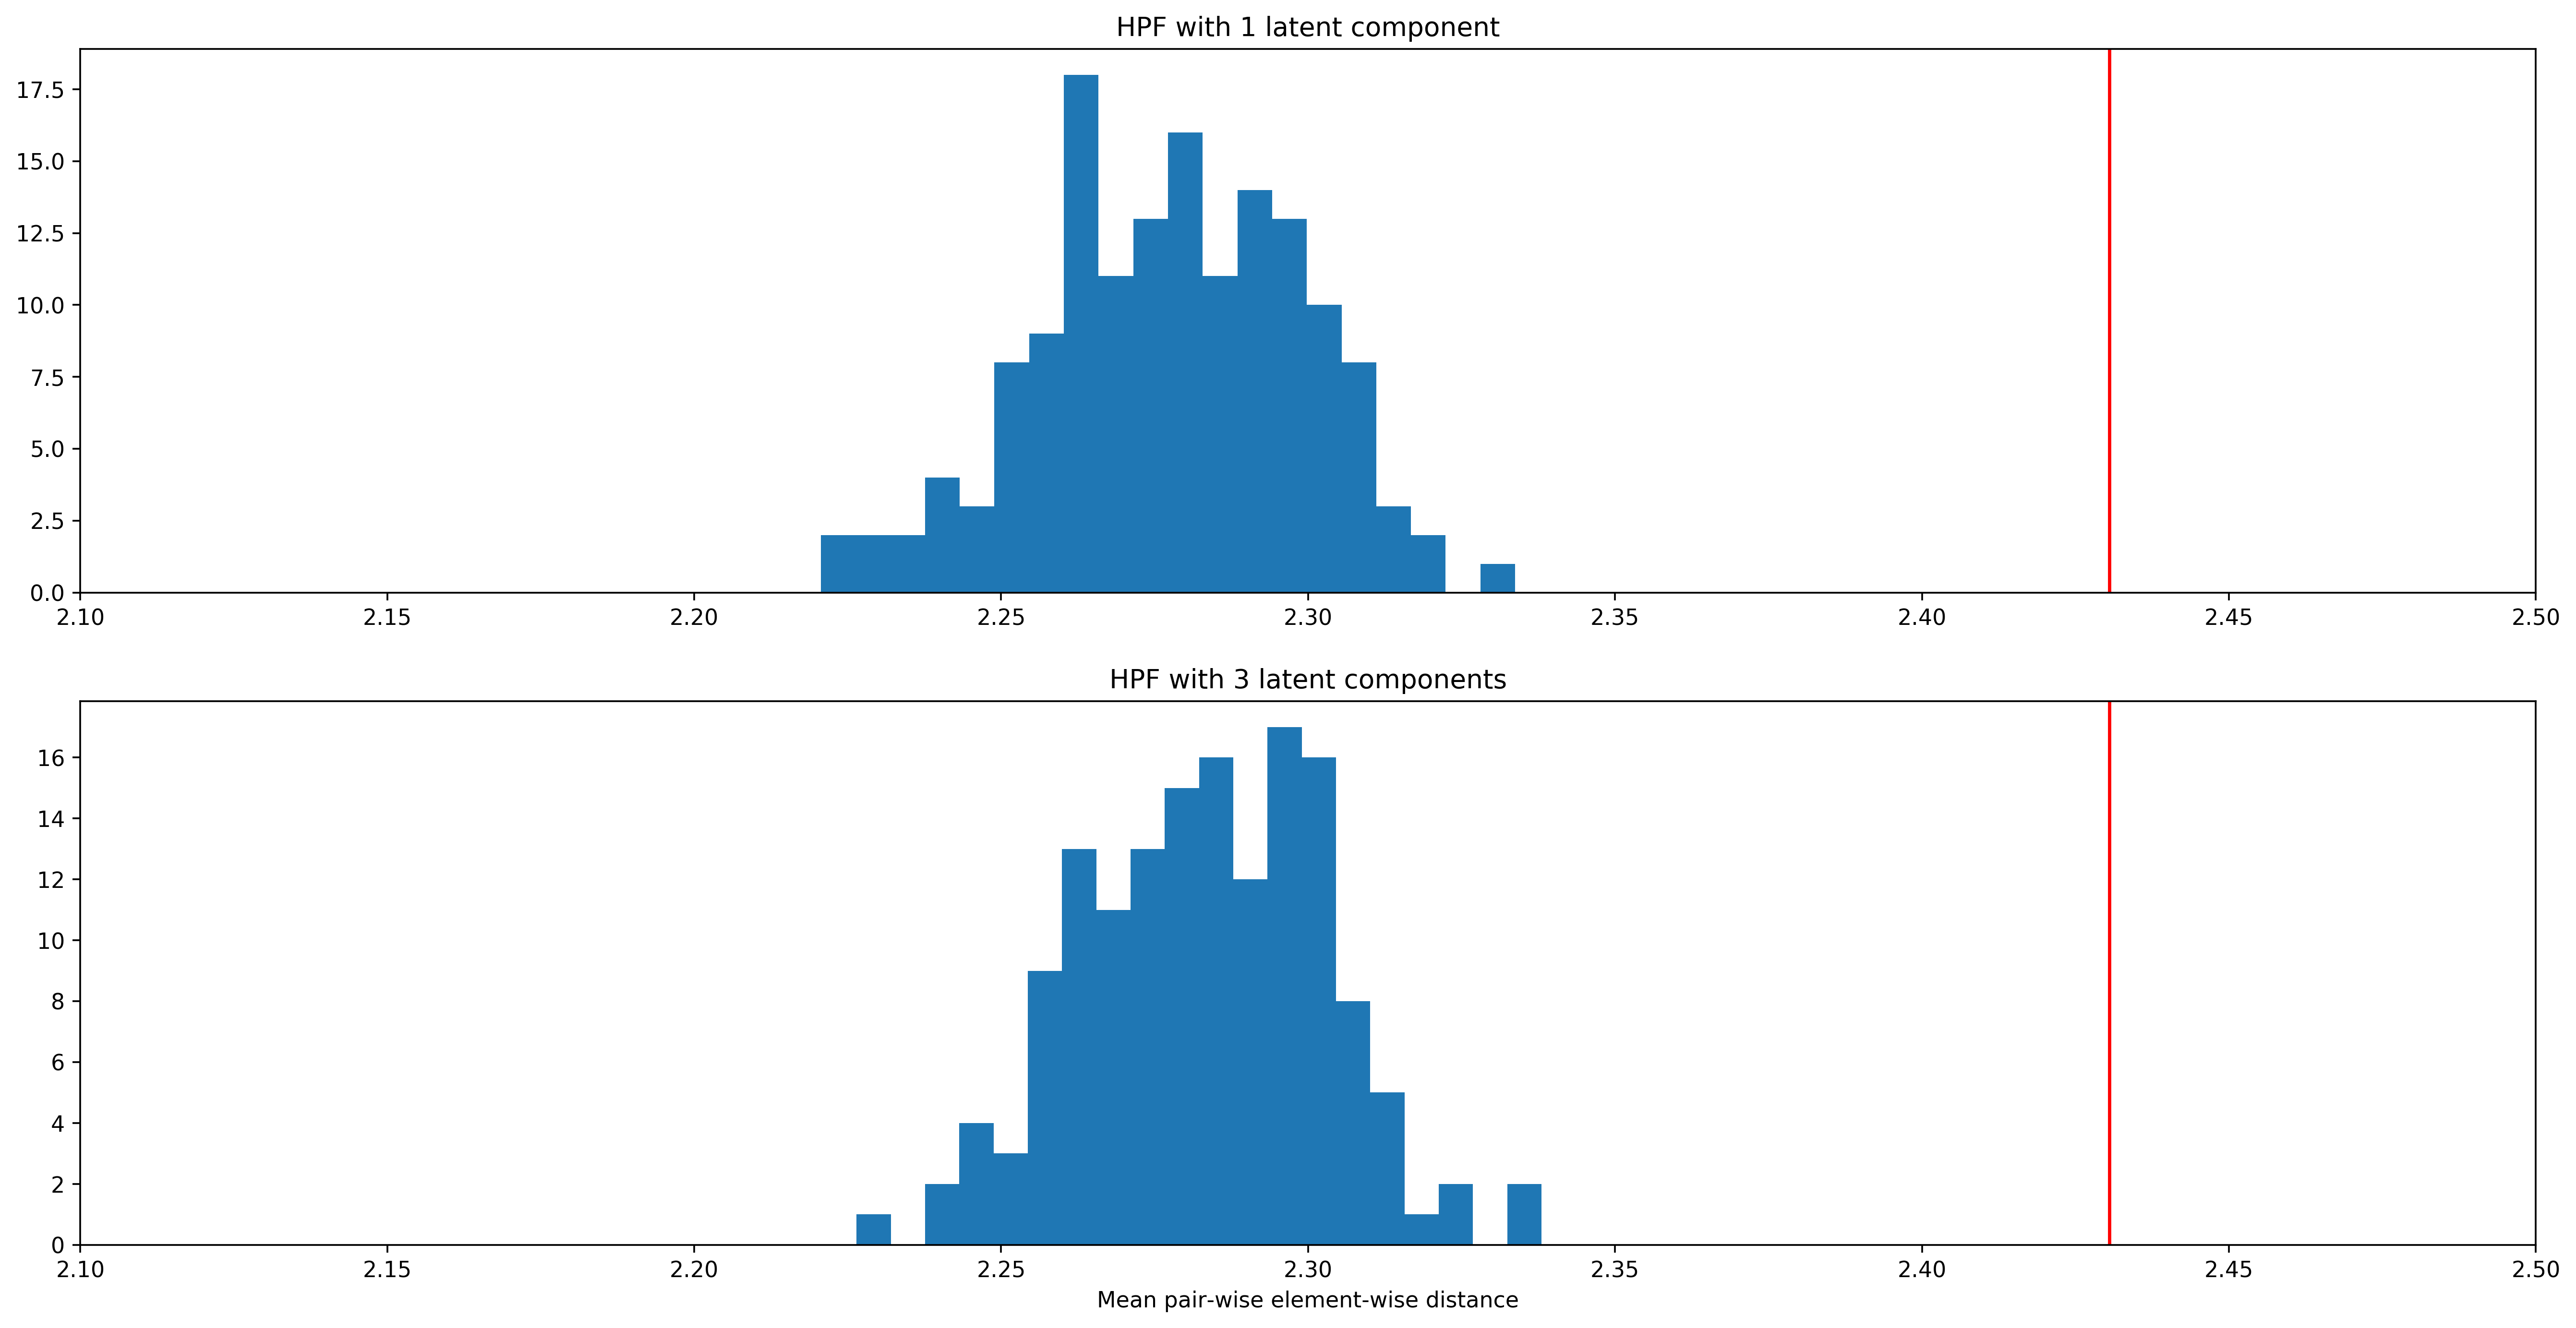

In [140]:
plt.figure(figsize=(20, 10), dpi=330)

plt.subplot(2, 1, 1)
plt.title('HPF with 1 latent component')
plt.hist(pred_post_test_stats_1lc, bins=20)
plt.axvline(data_test_stat, c='red')
plt.xlim((2.1, 2.5))

plt.subplot(2, 1, 2)
plt.title('HPF with 3 latent components')
plt.hist(pred_post_test_stats_3lc, bins=20)
plt.axvline(data_test_stat, c='red')
plt.xlabel('Mean pair-wise element-wise distance')
plt.xlim((2.1, 2.5))

plt.show()

Needless to say, the p-value here would be very small. As we suspected before, even though we might have captured some mode very well (thus, low autocorrelation), we could have missed other modes. This relates to the section 2.2. There I mentioned that we use number of generative processes $U=1$ under the assumption that all these molecules are fairly similar. However, as we can see, the test statistic on the original dataset is quite a bit larger. This means that in actuality, the molecules were quite more different from one another. In other words, they could have come from different generative processes and just happen to share the inhibitory property, but in terms of invidual molecular structure, they might be different. With $U=1$, even when we added more latent components, the test failed. Thus, we should consider the hierarchical model for the observed molecules.

The new hierarchical model is defined below. However, we will not run it due to computation constraints of my laptop. It will not be able to finish inference within the reasonable timeframe. What one could do is to mini-batch the dataset row-wise and perform parallel computation of the posteriors and merge all the calculations back together.

In [141]:
# Stan model for Hierarchical Poisson factorization
hpf_stan_2 = ''' 

data {
    int<lower=1> num_molec;  // number of molecules
    int<lower=1> num_lat_comp;  // number of latent components
    int<lower=1> num_feat;  // number of features
    
    real<lower=0> alpha_xi;  // hyperpriors for latent components
    real<lower=0> beta_xi;
    real<lower=0> alpha_theta;
    
    real<lower=0> alpha_eta;  // hyperpriors for features
    real<lower=0> beta_eta;
    real<lower=0> alpha_beta;
    
    int<lower=0, upper=1> obs[num_molec, num_feat];  // feature observations
}

parameters {
    vector<lower=0>[num_molec] xi;
    matrix<lower=0>[num_molec, num_lat_comp] theta;
    
    vector<lower=0>[num_feat] eta;
    matrix<lower=0>[num_feat, num_lat_comp] beta;
}

model {
    for (u in 1:num_molec) {
        xi[u] ~ gamma(alpha_xi, beta_xi);
        for (k in 1:num_lat_comp)
            theta[u, k] ~ gamma(alpha_theta, xi[u]);
    }
    
    for (i in 1:num_feat) {
        eta[i] ~ gamma(alpha_eta, beta_eta);
        for (k in 1:num_lat_comp)
            beta[i, k] ~ gamma(alpha_beta, eta[i]);
    }
    
    for (u in 1:num_molec)
        for (i in 1:num_feat)
            obs[u, i] ~ poisson(dot_product(theta[u], beta[i]));
}

'''

hpf_model_2 = pystan.StanModel(model_code=hpf_stan_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b99436679e16a5324eebe8992888fb8 NOW.


## Section 4: Classification
### 4.1. Classification with inference
Let's assume our model fitted just fine (e.g., we used the hierarchical model for individual molecules). That means we have the underlying process that can generate molecules with inhibitory capability. Now, we should check if a new molecule came from this model or not. We can reuse the same test statistic above to quantify "how far" that molecule is from the model. So we would calculate the distance between the new molecule and each of the generated and then take the average.

This time, thought, we don't use the conventional p-value to determine if the new molecule belongs or not. Instead, we propose many (symmetrical) percentile thresholds and try doing classification with them. Whichever has the best classification metric (discussed is section 4.2) would win.

In [169]:
def get_percentile(new_molec, post_pred_samples, post_pred_stats):
    num_comb = post_pred_samples.shape[0]
    mean_dist = 0
    
    for sample_molec in post_pred_samples:
        mean_dist += elementwise_distance(new_molec, sample_molec) / num_comb
        
    percentile = sts.percentileofscore(post_pred_stats, mean_dist)
        
    return percentile

In [170]:
# merging the zero labels to get the validation dataset
cdk2_not_inhibitors = pk_datasets['cdk2'].fetch_samples_with_label(label=0)
order = np.arange(X_test.shape[0] + cdk2_not_inhibitors['hash_features'].shape[0])
np.random.shuffle(order) # mix up inhibitors and non-inhibitors

X_val = np.vstack([X_test, cdk2_not_inhibitors['hash_features']])[order]
y_val = np.hstack([y_test, cdk2_not_inhibitors['labels']])[order]

In [171]:
# might take a while to run
# let's get the percentiles first then we can decide how to classify them
perc_1lc = [] # storage for percentiles per model
perc_3lc = []

for molec in X_val:
    perc_1lc.append(get_percentile(molec, hpf_posterior_pred(cdk2_fit_1lc), pred_post_test_stats_1lc))
    perc_3lc.append(get_percentile(molec, hpf_posterior_pred(cdk2_fit_3lc), pred_post_test_stats_3lc))

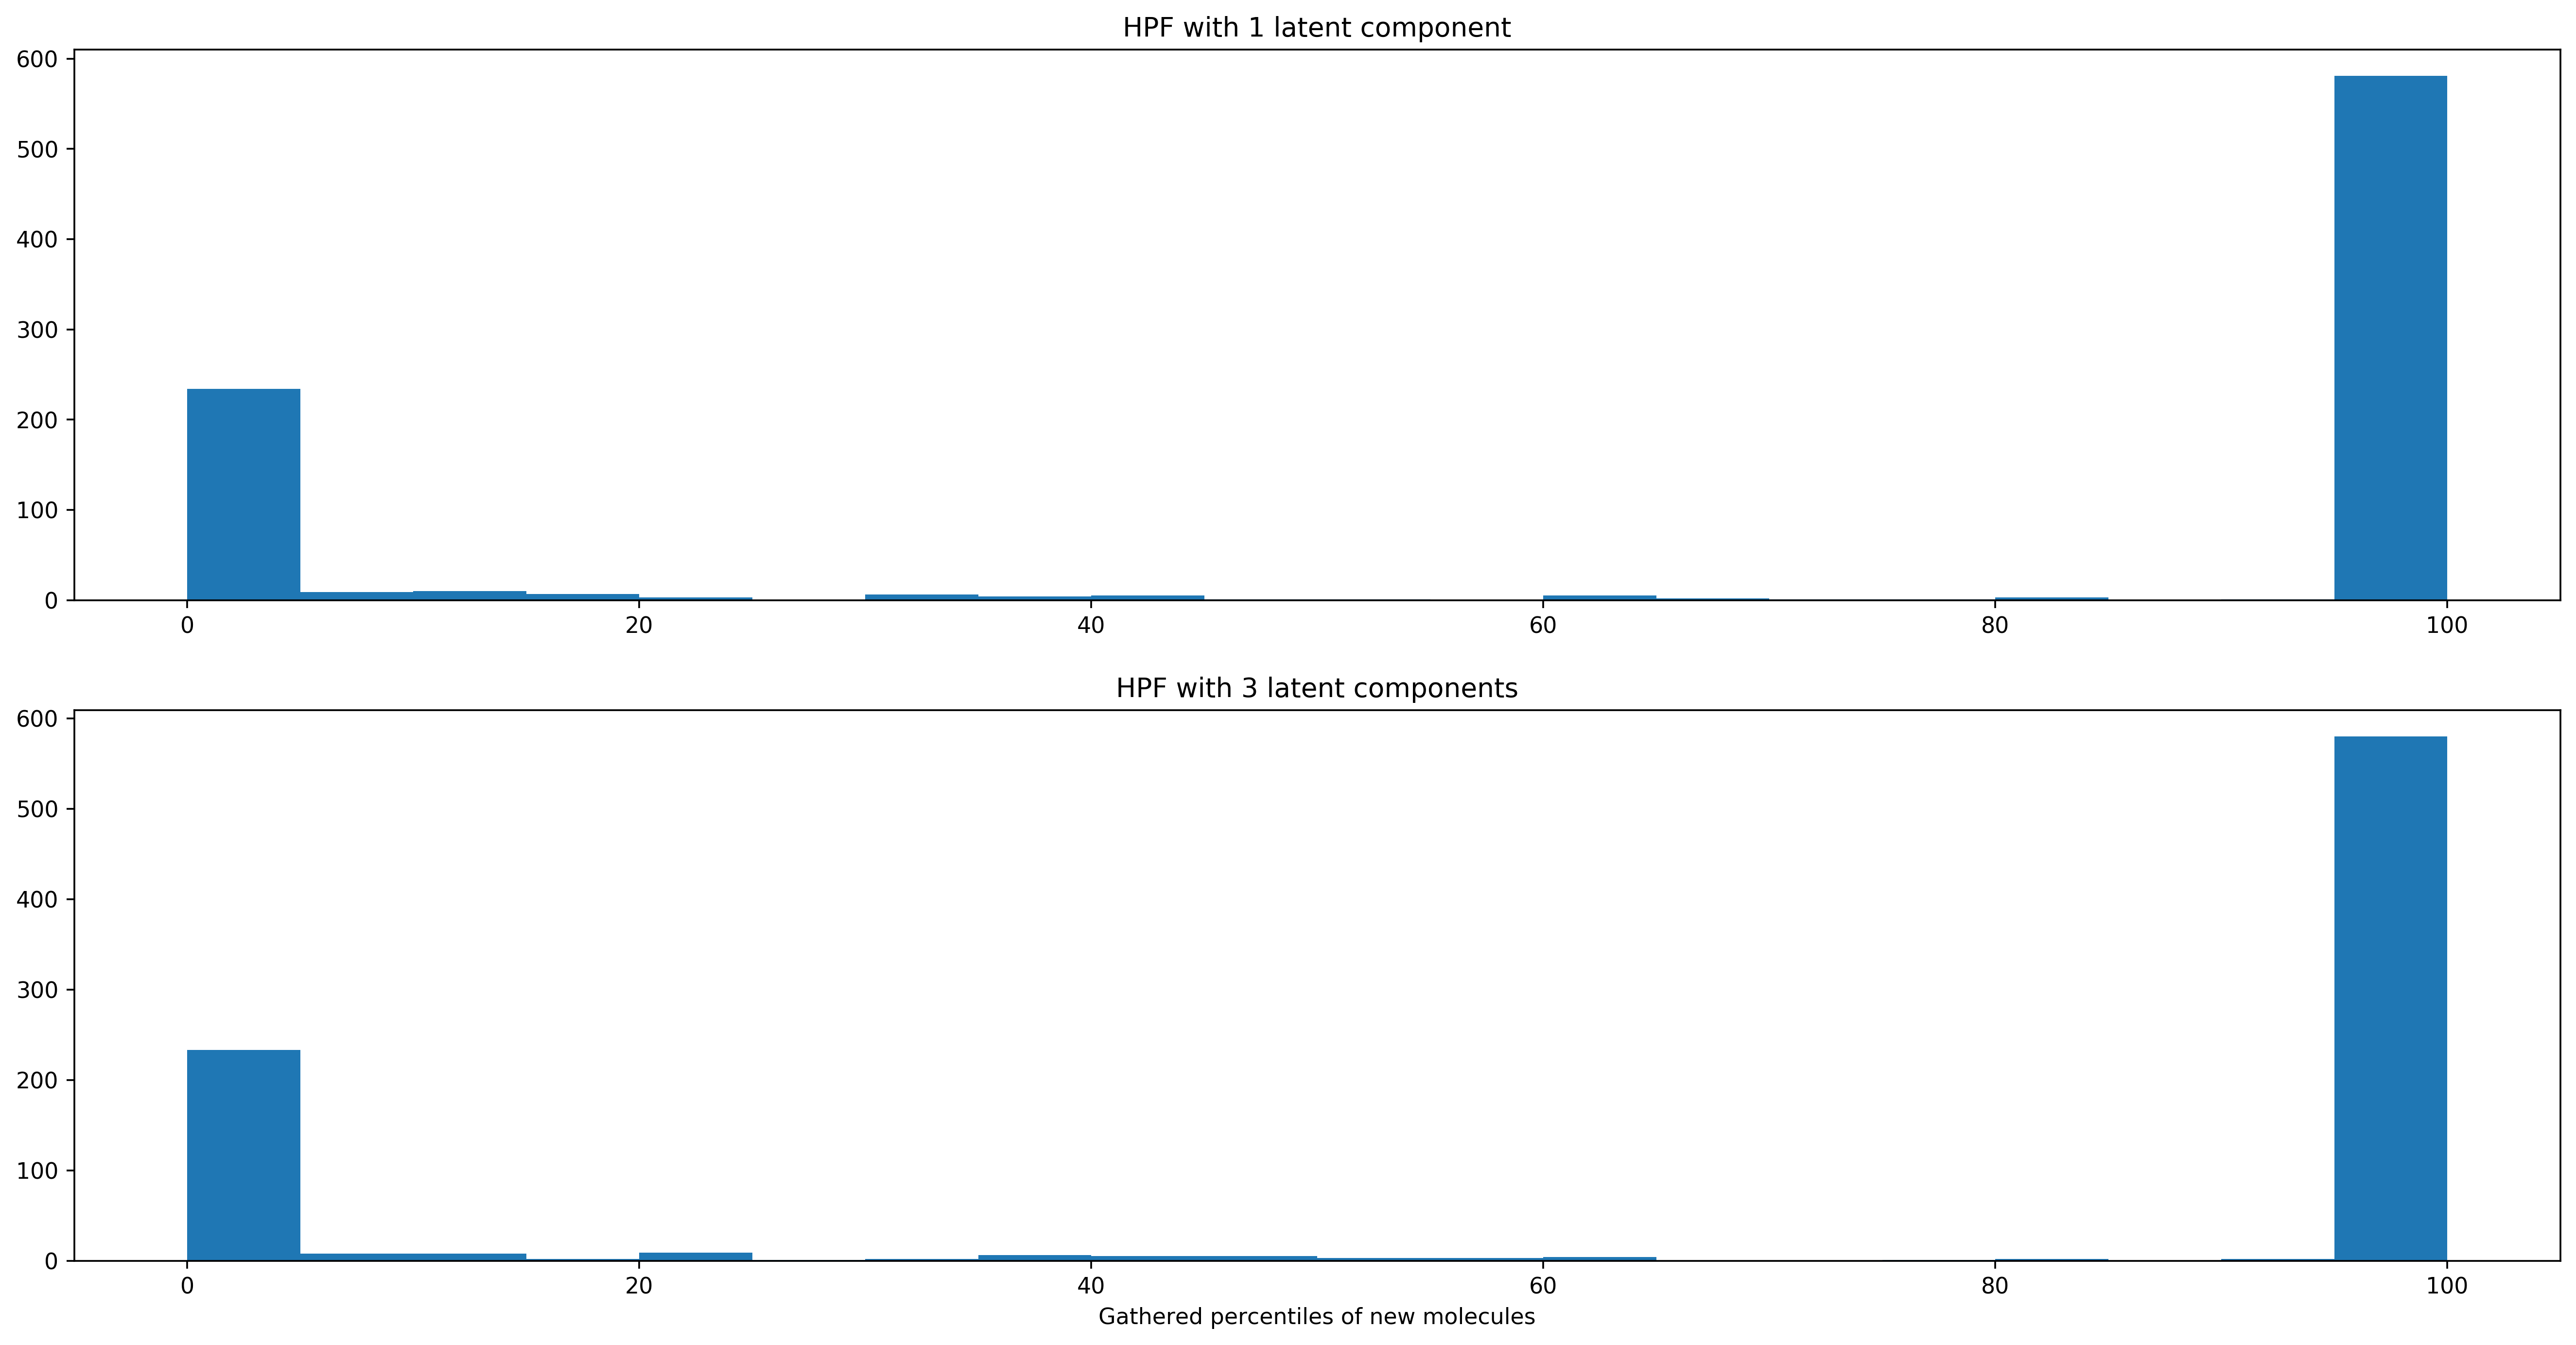

In [173]:
plt.figure(figsize=(20, 10), dpi=330)

plt.subplot(2, 1, 1)
plt.title('HPF with 1 latent component')
plt.hist(perc_1lc, bins=20)

plt.subplot(2, 1, 2)
plt.title('HPF with 3 latent components')
plt.hist(perc_3lc, bins=20)
plt.xlabel('Gathered percentiles of new molecules')

plt.show()

Seems like due to the fact that our model does not fit the original data well enough, it also does not fit the test positive samples. Hence, we have many samples that are pushed outside of the posterior predictive distribution.

### 4.2. Validation metrics
For classification, we can use the standard F1 score to maximize separation between two classes (inhibitor and non-inhibitor). Alternatively, we can modify the F1 score to prioritize precision since most molecules out in the wild do not have inhibitory capabilities. Practically this makes sense because researchers only want to synthesize a molecule if they are pretty sure it'd work -- otherwise, it's costly to produce thousands and thousands of unfiltered molecules. The formula for F1 score is as such:
$$F_1 = 2*\dfrac{precision*recall}{precision+recall}$$

Let's say we would like to increase our precision twice (it's not bad for us to have false negatives since we want to decrease the set of molecules to test out in practicality). Then, we can do a weighted F-score:

$$F_{\beta} = (1+\beta^2)*\dfrac{precision*recall}{(\beta^2 *precision)+recall}$$

When $\beta < 1$, more weight is put on precision which is what we need.

In [178]:
# symmetrize the percentiles
perc_1lc_sym = np.abs(np.array(perc_1lc) - 50)
perc_3lc_sym = np.abs(np.array(perc_3lc) - 50)

Let's propose some positive thresholds with which we can try to classify if a new molecule belongs to the inhibitor class or not.

In [199]:
thresholds = np.linspace(10, 50, 9)
y_pred_1lc_storage = []
y_pred_3lc_storage = []

for i, thres in enumerate(thresholds):
    y_pred_1lc_storage.append(np.zeros(y_val.shape))
    y_pred_3lc_storage.append(np.zeros(y_val.shape))
    
    y_pred_1lc_storage[i][perc_1lc_sym <= thres] = 1
    y_pred_3lc_storage[i][perc_3lc_sym <= thres] = 1

In [200]:
# calculate f-beta scores
precision_gain = 2 # we weight importance of precision twice as much

for i, thres in enumerate(thresholds):
    f_score_1lc = fbeta_score(y_val, y_pred_1lc_storage[i], beta=1/precision_gain)
    f_score_3lc = fbeta_score(y_val, y_pred_3lc_storage[i], beta=1/precision_gain)
    print("thres={0}%, 1 lat comp, f-score={1}".format(thres, f_score_1lc))
    print("thres={0}%, 3 lat comp, f-score={1}".format(thres, f_score_3lc))
    print()

thres=10.0%, 1 lat comp, f-score=0.03484320557491289
thres=10.0%, 3 lat comp, f-score=0.07836990595611285

thres=15.0%, 1 lat comp, f-score=0.06269592476489028
thres=15.0%, 3 lat comp, f-score=0.16713091922005574

thres=20.0%, 1 lat comp, f-score=0.08547008547008547
thres=20.0%, 3 lat comp, f-score=0.1771117166212534

thres=25.0%, 1 lat comp, f-score=0.08450704225352113
thres=25.0%, 3 lat comp, f-score=0.1752021563342318

thres=30.0%, 1 lat comp, f-score=0.09433962264150944
thres=30.0%, 3 lat comp, f-score=0.17031630170316303

thres=35.0%, 1 lat comp, f-score=0.1338199513381995
thres=35.0%, 3 lat comp, f-score=0.1756440281030445

thres=40.0%, 1 lat comp, f-score=0.15521064301552104
thres=40.0%, 3 lat comp, f-score=0.17429193899782136

thres=45.0%, 1 lat comp, f-score=0.15274949083503053
thres=45.0%, 3 lat comp, f-score=0.19038076152304614

thres=50.0%, 1 lat comp, f-score=0.3399093575046654
thres=50.0%, 3 lat comp, f-score=0.3399093575046654



Hooray! At least in classification, the 3 latent component HPF seems do do better. The classification score is far from ideal. It does worse than randomly guessing 0 or 1. The fact that at maximum threshold the ratio is only that much is because there are fewer positive validation samples, and a lot of negative samples are actually inside the modeled posterior predictive distribution. Looking at the end of section 3.2. again, we can see that if we were centered on that red line, we probably would be further away from the negative samples and closer to the positive. This would then improve the separability. 

At threshold below 50% (not calling everything a 1), the 3 lat component seems to do better at all thresholds. Seems like adding more latent components allows more flexibility in modeling the molecule to structure relationship.

## Section 5: Synthesis
### 5.1. Discussion of the models

Using the hierarchical Poisson factorization model seems natural in the case of modeling molecules. Similar to user-movie recommendation, there are latent components (properties) implying chemical properties (e.g., hydrophobicity, binding affinity, etc.) that we do not necessary observe directly from the molecular structure. We have observed that when we add more parameters to model the latent components, we saw improvement in the classification task, implying that the fit is slightly better. 

There are various ways we can improve the models (at the cost of computation time):
- Increase the number of latent components
- Add hierarchical modeling for the molecules

It would be really interesting to see how a properly-fitted model would be able to generate inhibitory molecules "out of thin air" with high precision.

### 5.2. Next steps
We used modulus hashing to arbitrarily reduce the dimension of the dataset. Undoubtedly, there could have been collisions where two molecules (might be quite different) mapped to the same hash. This can lead to the situation of oversampling when we have a duplicate datapoint that misleadingly adjusts the posterior towards the duplicate. To avoid this, we can try to apply the correlation explanation to "meaningfully" reduce the dimensionality of our data. To optimize for the run time, we can use mini-batch updates as mentioned by CorEx authors [here](https://github.com/gregversteeg/bio_corex/#computational-complexity).

The dataset does not provide the original generation process of the fingerprints. This would be useful for reverse engineering where we can display the generated molecules based on the generated features from the predictive posterior. Visualizing the molecular structure is important for scientists to further the understanding of molecular properties of structures and compounds.

## References
1. Bhullar, K. S., Lagarón, N. O., McGowan, E. M., Parmar, I., Jha, A., Hubbard, B. P., & Rupasinghe, H. P. V. (2018). Kinase-targeted cancer therapies: progress, challenges and future directions. Molecular Cancer, 17(1). doi:10.1186/s12943-018-0804-2 
2. Gopalan, P., Hofman, J., Blei, D. M. (2014). Scalable Recommendation with Poisson Factorization. Retrieved from https://arxiv.org/pdf/1311.1704.pdf
3. Landrum, G. (2012). Fingerprints in the RDKit. Novartis Institutes for BioMedical Research. Retrieved from https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf
4. Ver Steeg, G., Galstyan, A. (2015). Maximally Informative Hierarchical Representations of High-Dimensional Data. Retrieved from https://arxiv.org/abs/1410.7404 
5. Wikipedia contributors (2019). Protein kinase. Retrieved from https://en.wikipedia.org/wiki/Protein_kinase
6. Xiao, K. (2019). Cancer Inhibitors [Dataset]. Retrieved from https://www.kaggle.com/xiaotawkaggle/inhibitors